In [1]:
## 训练一个好的ML模型，需要模型评估和参数寻优

In [2]:
## 通过管道创建工作流 pipelines(Sklearn中的pipeline类)

In [3]:
### 读取Breast Cancer Wisconsin数据集
### 然后把y转化成0，1

In [7]:
import pandas as pd
import numpy as np
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header = None)

In [8]:
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:,2:].values
y = df.loc[:,1].values
np.unique(y)

array(['B', 'M'], dtype=object)

In [9]:
le = LabelEncoder()
y = le.fit_transform(y)
np.unique(y)

array([0, 1])

In [10]:
### 接着创建训练集和测试集


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.20, random_state = 1)

In [14]:
### 将transformer和estimator放入同一个pipeline
### 用pipeline把StandardScaler,PCA和LR连接起来

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [18]:
pipe_lr = Pipeline([('scl',StandardScaler()),
                    ('pca', PCA(n_components = 2)),
                    ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [19]:
print('Test Accuracy: %.3f' %pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


In [35]:
## K折交叉验证评估模型性能
### 交叉验证是如何评估模型泛化能力的方差

In [23]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold

In [25]:
kfold = StratifiedKFold(y = y_train,
                       n_folds = 10,
                       random_state = 1)
scores = []

In [27]:
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold:%s, Class dist.:%s, Acc:%.3f' % (k+1, np.bincount(y_train[train]),score))

Fold:1, Class dist.:[256 153], Acc:0.891
Fold:2, Class dist.:[256 153], Acc:0.978
Fold:3, Class dist.:[256 153], Acc:0.978
Fold:4, Class dist.:[256 153], Acc:0.913
Fold:5, Class dist.:[256 153], Acc:0.935
Fold:6, Class dist.:[257 153], Acc:0.978
Fold:7, Class dist.:[257 153], Acc:0.933
Fold:8, Class dist.:[257 153], Acc:0.956
Fold:9, Class dist.:[257 153], Acc:0.978
Fold:10, Class dist.:[257 153], Acc:0.956


In [28]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


In [29]:
### sklearn 还有一个直接得到交叉验证评估结果的方法crss_val_score

In [30]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator = pipe_lr,
                        X = X_train,
                        y = y_train,
                        cv = 10,
                        n_jobs = 1)

In [31]:
print('CV accuracy scores : %s' %scores)

CV accuracy scores : [0.89130435 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]


In [34]:
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


In [36]:
## 使用学习曲线和验证曲线，调试算法 
## Debugging algorithms with learning and validation curves

In [37]:
### 认识学习曲线

In [41]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve #sklearn.model_selection 代替sklearn.learning_curve

In [42]:
pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('clf', LogisticRegression(
    penalty = 'l2', random_state=0))
])


In [44]:
train_sizes, train_scores, test_scores = learning_curve(estimator = pipe_lr,
                                                      X = X_train,
                                                      y = y_train,
                                                      train_sizes = np.linspace(0.1, 1.0, 10),
                                                      cv = 10,
                                                      n_jobs = 1)

In [45]:
train_mean = np.mean(train_scores, axis = 1)

In [46]:
train_std = np.std(train_scores, axis = 1)

In [47]:
test_mean = np.mean(test_scores, axis = 1)

In [48]:
test_std = np.std(test_scores, axis = 1)

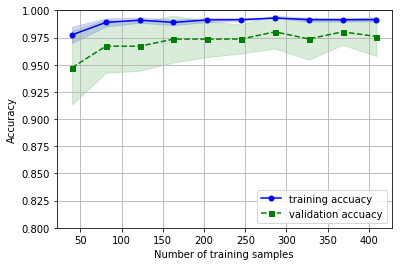

In [50]:
plt.plot(train_sizes, train_mean,
        color = 'blue', marker = 'o',
        markersize = 5, 
        label = 'training accuacy')
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha = 0.15, color = 'blue')
plt.plot(train_sizes, test_mean,
        color = 'green', linestyle = '--',marker = 's',
        markersize = 5, 
        label = 'validation accuacy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha = 0.15, color = 'green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.0])
plt.show()

In [52]:
## 用验证曲线解决过拟合和欠拟合
### 验证曲线与学习曲线，不同的是滑出的是不同参数下模型的准确率而不是不同训练集大小下的准确率
### 实际上是找最有参数的过程

In [53]:
from sklearn.model_selection import validation_curve

In [54]:
param_range= [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [56]:
train_scores, test_scores = validation_curve(estimator = pipe_lr,
                                            X = X_train,
                                            y = y_train,
                                            param_name = 'clf__C',
                                            param_range = param_range,
                                            cv = 10)

In [57]:
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

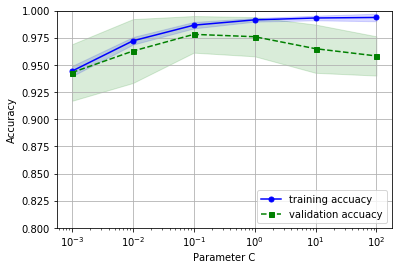

In [58]:
plt.plot(param_range, train_mean,
        color = 'blue', marker = 'o',
        markersize = 5, 
        label = 'training accuacy')
plt.fill_between(param_range,
                train_mean + train_std,
                train_mean - train_std,
                alpha = 0.15, color = 'blue')
plt.plot(param_range, test_mean,
        color = 'green', linestyle = '--',marker = 's',
        markersize = 5, 
        label = 'validation accuacy')
plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                alpha = 0.15, color = 'green')
plt.grid()
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.0])
plt.xscale('log')
plt.show()

In [59]:
## 通过网格搜索调参 Fine-tuning ML models via grid search

In [60]:
### ML的参数有两种，一种是从训练集中学习到的参数，比如LR的权重参数；
### 另一类是模型的超参数，就是需要人工设定的参数，比如正则项系数或决策树的深度

In [61]:
### 网格搜索实际上就是暴力搜索而已。我们实现为每个参数设定一组值，然后穷举各种参数组合，找到最好的一组

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [68]:
pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state = 1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{
    'clf__C': param_range,
    'clf__kernel' : ['linear']},
    {
        'clf__C' : param_range,
        'clf__gamma' : param_range,
        'clf__kernel' : ['rbf']
}]


In [69]:
gs = GridSearchCV(estimator = pipe_svc,
                 param_grid = param_grid,
                 scoring = 'accuracy',
                 cv = 10,
                 n_jobs = -1)

In [70]:
gs = gs.fit(X_train, y_train)

In [73]:
print(gs.best_score_)

0.978021978021978


In [74]:
print(gs.best_params_)

{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [75]:
clf = gs.best_estimator_ # 直接利用最优参数建模

In [76]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))])

In [77]:
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


In [78]:
### GridSearchCV 虽然不错，但穷举过于耗时，sklearn中还实现了随机搜索
### 使用RandomizedSearchCV类，随机采样出不同的参数组合

In [79]:
## 通过嵌套交叉验证选择算法 algorithm selection with nested cross-validation
### 在sklearn 中使用嵌套交叉验证：

In [80]:
gs = GridSearchCV(estimator = pipe_svc,
                 param_grid = param_grid,
                 scoring = 'accuracy',
                 cv = 10,
                 n_jobs = -1)

In [81]:
scores = cross_val_score(gs, X, y, scoring = 'accuracy', cv = 5)

In [82]:
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy: 0.972 +/- 0.012


In [83]:
### 使用嵌套交叉验证比较SVM和决策树分类器：

In [84]:
from sklearn.tree import DecisionTreeClassifier

In [87]:
gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 0),
                 param_grid = [{
                     'max_depth':[1,2,3,4,5,6,7,None]
                 }],
                  scoring = 'accuracy',
                  cv = 5
                 )
scores = cross_val_score(gs,
                        X_train,
                        y_train,
                        scoring = 'accuracy',
                        cv = 5)

In [88]:
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))

CV accuracy: 0.908 +/- 0.045


In [90]:
### 除了accuracy这个指标，
### 查准率（precision）、查全率(recall)，F1值（F1-score）
### 都是不错的评价Model性能的指标

In [91]:
## 混淆矩阵 confusion matrix,能够展示学习算法表现的矩阵
## 混淆矩阵是一个平方矩阵，其中记录了一个分类器的TP(true positive)、TN(ture negative)、FP(false positive)和FN(false negative)

In [92]:
### sklearn 中的confusion_matrix函数

In [93]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)

In [94]:
print(confmat)

[[71  1]
 [ 2 40]]


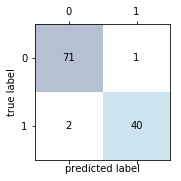

In [97]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i,
               s = confmat[i,j],
               va = 'center', ha = 'center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [ ]:
## 优化分类模型的查准率和查全率 optimizing the precision and recall of a classification model